My model has ~63% accuracy accurately predicting a movies rating to be above or below the median rating, 8.3.  My model performs best when trying to predict ratings of recently released films.

I took the top 250 movies off of IMDB and created a model predicting whether a movie was above or below the median rating of the 250 movies.  Dropping nulls put the total count down to 246 movies.  I Count Vectorized 'Writers', 'Directors', 'Actors', 'Genres', and 'Country'; and I included 'Year', 'imdbRating', 'imdbVotes', and 'Runtime'.  I did not include 'Awards' in my model as doing so would prevent my model from being able to accurately model recently released films.  I also didn't include Metascore since Metascore is pretty much what I'm trying to predict but labeled under a different metric.  I then created two different sets, one with limited features and one with all features.  I also used Eigan Vectors to reduce both sets of features in two additional sets.  I then ran Extra Trees and Random Forest on the select feature set, full feature set, and select/full bucket sets.  I found that 'Extra Trees Default Select Feature Accuracy' and 'Random Forest Default Select Feature Accuracy' were the two most accurate models with minimal difference between the two.  With random chance being around 51% for this dataset, my model makes 10-15% more accurate predictions at ~63% accuracy.  The top five features with highest importance are 'imdbVotes', 'Year', 'Runtime', 'Country: uk', and 'Genre: adventure'.

With more time, I could emplement additional feature categories to make the model more accurate.  I also need to figure out why adding more features decreases the accuracy.  My model use to be ~5% more accurate until I changed stuff and messed around.  So if I had more time I'd fix that too.

In [1]:
import pandas as pd
import urllib
import numpy as np
import requests
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns

from imdbpie import Imdb
from operator import itemgetter

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, classification_report, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cross_validation import KFold, cross_val_score, cross_val_predict, train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.grid_search import GridSearchCV

from nltk.tag import pos_tag
from nltk.tokenize import WordPunctTokenizer

from unidecode import unidecode

%matplotlib inline

In [2]:
randy_state = 77

In [3]:
#Uses api to get top 250 movies off of IMDB
def get_top_250():
    response = requests.get('http://www.imdb.com/chart/top')
    html = response.text
    entries = re.findall("<a href.*?/title/(.*?)/", html)
    return list(set(entries))

In [4]:
#Gets the data for each movie
def get_entry(entry):
    res = requests.get('http://www.omdbapi.com/?i='+entry)
    if res.status_code != 200:
        print entry, res.status_code
    else:
        print '.',
    try:
        j = json.loads(res.text)
    except ValueError:
        j = None
    return j

In [5]:
#Performs a cross_val_score
def do_cross_val(model, alt):
    cv = KFold(len(y), shuffle=True)
    scores = cross_val_score(model, alt, y, cv=cv, n_jobs=-1)
    return scores.mean()

In [6]:
#Creates buckets
def eigenBucket(Ex):
    f_df = StandardScaler().fit_transform(Ex)
    cov_mat = np.cov(f_df.T)

    eigenValues, eigenVectors = np.linalg.eig(cov_mat)
    eig_pairs = [(np.abs(eigenValues[i]), eigenVectors[:,i]) for i in range(len(eigenValues))]
    eig_pairs = sorted(eig_pairs, key=itemgetter(0))
    eig_pairs.reverse()

    pca = PCA(n_components=50)
    pca.fit(f_df)

    shape_size = eig_pairs[0][1].shape[0]

    W = np.hstack((eig_pairs[0][1].reshape(shape_size,1), eig_pairs[1][1].reshape(shape_size,1))) # Our transformation matrix
    return f_df.dot(W)

In [7]:
#Function to run the ExtraTrees and RandomForest Classifiers with several datasets.
#(X, y, "description", "ETC"|"RFC")
def extraTreestrial(Ex, Why, strang, classif):
    if classif == "ETC":
        etc = ExtraTreesClassifier(random_state=randy_state, n_jobs=-1)
        etc.fit(Ex, Why)
        print strang, do_cross_val(etc, Ex).round(3)
    elif classif == "RFC":
        etc = RandomForestClassifier(random_state=randy_state, n_jobs=-1)
        etc.fit(Ex, Why)
        print strang, do_cross_val(etc, Ex).round(3)

In [8]:
#Runs Count Vectorizer for select columns
def tmnt(nam, rang, strng):
    cvec = CountVectorizer(ngram_range=(rang,rang))
    cvec.fit(df[nam])

    columns = [nam + ': '+c for c in cvec.get_feature_names()]

    director_df  = pd.DataFrame(cvec.transform(df[nam]).todense(), columns=columns)
    
    if strng == "FULL":
        return director_df
    elif strng == "SELECT":
        temp_df = director_df
        k_df = temp_df[[ind for ind, x in enumerate(director_df) if director_df[columns[ind]].sum() > 4]]

        return k_df

In [9]:
entries = get_top_250()

In [10]:
entries_dict_list = [get_entry(e) for e in entries]

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


In [11]:
df = pd.DataFrame(entries_dict_list)
del df['Type']
del df['Poster']
del df['Response']
del df['Metascore']
del df['Plot']

In [12]:
#Converts Runtime to INT
df['Runtime'] = pd.Series([int(x.split(' ')[0]) for x in df['Runtime']])

#Converts Year to INT
df['Year'] = pd.Series([int(x) for x in df['Year']])

#Converts IMDB Rating to FLOAT
df['imdbRating'] = pd.Series([float(x) for x in df['imdbRating']])

#Converts IMDB Votes to INT
df['imdbVotes'] = pd.Series([int(x.replace(',', '')) for x in df['imdbVotes']])

#df['Year'] = MinMaxScaler().fit_transform(df['Year'].astype(float).reshape(-1, 1))

In [13]:
#Converts N/A to NaNs in order to be dropped.
df['Awards'] = df['Awards'].replace('N/A', np.nan)
#May reconsider above.  Tokenizing may fix need for it.

#Drops NaNs
df.dropna(inplace=True)
df = df.reset_index(drop=True)

In [14]:
df.tail(1)

,Actors,Awards,Country,Director,Genre,Language,Rated,Released,Runtime,Title,Writer,Year,imdbID,imdbRating,imdbVotes
245,"Sener Sen, Ugur Yücel, Sermin Hürmeric, Yesim ...",2 wins.,Turkey,Yavuz Turgul,"Crime, Drama, Thriller",Turkish,N/A,29 Nov 1996,128,The Bandit,Yavuz Turgul,1996,tt0116231,8.6,34685


In [15]:
#Converts the text and removes everything inside of parenthesis
for x in range(len(df['Writer'])):
    df['Writer'][x] = unidecode(df['Writer'][x])
    df['Writer'][x] = re.sub(' \(.*?\)','',df['Writer'][x], flags=re.DOTALL).strip()

/Users/Jesse/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/Jesse/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [16]:
dummy_rated = pd.get_dummies(df["Rated"], prefix="rated: ")

In [17]:
final_df = pd.concat([tmnt('Writer', 2, "SELECT"), tmnt('Genre', 1, "SELECT")], axis=1)
final_df = pd.concat([final_df, tmnt('Actors', 2, "SELECT")], axis=1)
final_df = pd.concat([final_df, tmnt('Country', 1, "SELECT")], axis=1)
final_df = pd.concat([final_df, tmnt('Director', 2, "SELECT")], axis=1)
final_df = pd.concat([final_df, dummy_rated], axis=1)
final_df = pd.concat([final_df, df['Year']], axis=1)
final_df = pd.concat([final_df, df['Runtime']], axis=1)
final_df['Year'] = MinMaxScaler().fit_transform(final_df['Year'].astype(float).reshape(-1, 1))
final_df['Runtime'] = MinMaxScaler().fit_transform(final_df['Runtime'].astype(float).reshape(-1, 1))

In [18]:
alt_df = pd.concat([tmnt('Writer', 2, "FULL"), tmnt('Genre', 1, "FULL")], axis=1)
alt_df = pd.concat([alt_df, tmnt('Actors', 2, "FULL")], axis=1)
alt_df = pd.concat([alt_df, tmnt('Country', 1, "FULL")], axis=1)
alt_df = pd.concat([alt_df, tmnt('Director', 2, "FULL")], axis=1)
alt_df = pd.concat([alt_df, dummy_rated], axis=1)
alt_df = pd.concat([alt_df, df['Year']], axis=1)
alt_df = pd.concat([alt_df, df['Runtime']], axis=1)
alt_df['Year'] = MinMaxScaler().fit_transform(alt_df['Year'].astype(float).reshape(-1, 1))
alt_df['Runtime'] = MinMaxScaler().fit_transform(alt_df['Runtime'].astype(float).reshape(-1, 1))

In [43]:
X = final_df
X_alt = alt_df
y = df['imdbRating']>=df['imdbRating'].median()  #8.3

In [20]:
X_reduced = eigenBucket(X)
X_reduced_alt = eigenBucket(X_alt)

In [21]:
#Runs CrossVal on ExtraTreesClassifier
extraTreestrial(X, y, "   Extra Trees Default Select Feature Accuracy: ", "ETC")
extraTreestrial(X_reduced, y, "  Extra Trees Bucketed Select Feature Accuracy: ", "ETC")
extraTreestrial(X_alt, y, "     Extra Trees Default Full Feature Accuracy: ", "ETC")
extraTreestrial(X_reduced_alt, y, "    Extra Trees Bucketed Full Feature Accuracy: ", "ETC")

extraTreestrial(X, y, " Random Forest Default Select Feature Accuracy: ", "RFC")
extraTreestrial(X_reduced, y, "Random Forest Bucketed Select Feature Accuracy: ", "RFC")
extraTreestrial(X_alt, y, "   Random Forest Default Full Feature Accuracy: ", "RFC")
extraTreestrial(X_reduced_alt, y, "  Random Forest Bucketed Full Feature Accuracy: ", "RFC")

   Extra Trees Default Select Feature Accuracy:  0.565
  Extra Trees Bucketed Select Feature Accuracy: 

/Users/Jesse/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:373: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


 0.565
     Extra Trees Default Full Feature Accuracy:  0.516
    Extra Trees Bucketed Full Feature Accuracy:  0.496
 Random Forest Default Select Feature Accuracy:  0.577
Random Forest Bucketed Select Feature Accuracy:  0.553
   Random Forest Default Full Feature Accuracy:  0.593
  Random Forest Bucketed Full Feature Accuracy:  0.545


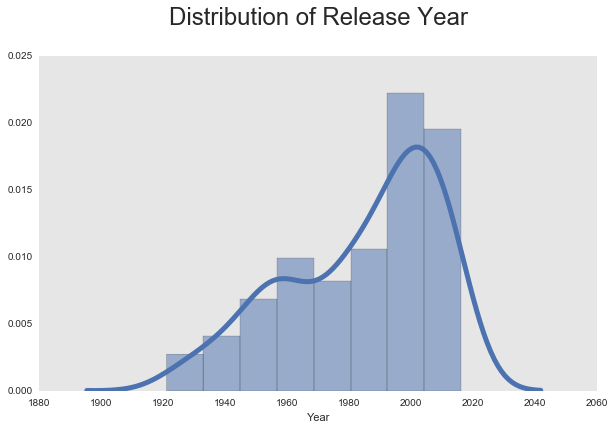

In [22]:
def distribution_plotter(column, data):
    sns.set(rc={"figure.figsize": (10, 6)})
    sns.set_style("dark", {"axes.facecolor": ".9"})
    sns.set
    dist = sns.distplot(data, hist_kws={'alpha':0.5}, kde_kws={'linewidth':5})
    dist.set_title('Distribution of ' + column + '\n', fontsize=24)

testy = df['Year']
testy = testy.dropna().to_frame()
distribution_plotter('Release Year', testy['Year'])

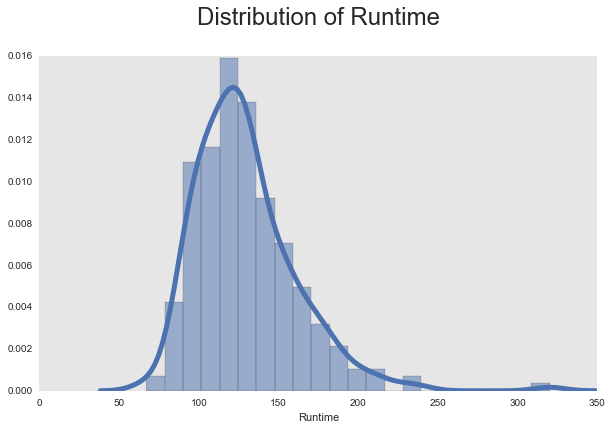

In [23]:
testy = df['Runtime']
testy = testy.dropna().to_frame()
distribution_plotter('Runtime', testy['Runtime'])

,et_importance
Year,0.031442
Runtime,0.012094
Genre: thriller,0.007879
Country: canada,0.007832
Country: uk,0.007757
Director: ingmar bergman,0.007411
Actors: faye dunaway,0.007030
Writer: frank pierson,0.006832
Writer: tullio pinelli,0.006343
Country: usa,0.006127


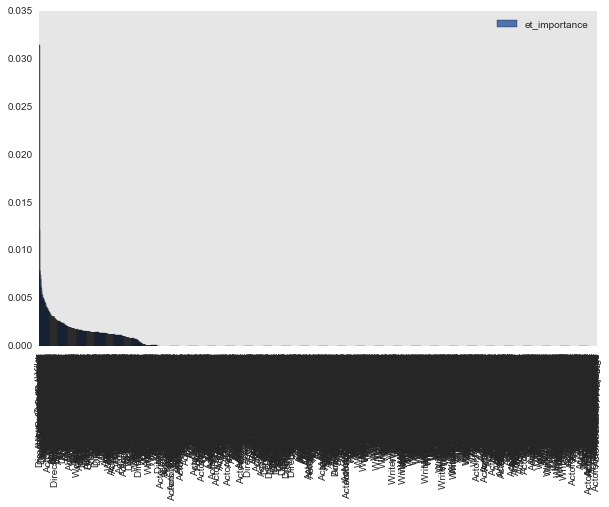

In [24]:
etc = RandomForestClassifier(random_state=randy_state, n_jobs=-1)
etc.fit(X_alt, y)

importances = pd.DataFrame(etc.feature_importances_,
                           index=X_alt.columns,
                           columns=['et_importance']).sort_values('et_importance', ascending=False)

                           
importances.plot(kind='bar')
importances.head(10)

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(final_df, y, test_size=0.6, random_state=77)

In [26]:
etc = RandomForestClassifier(class_weight="balanced", random_state=randy_state, n_jobs=-1)
etc.fit(X_train, Y_train)
y_pred = etc.predict(X_test)

In [27]:
print classification_report(Y_test,y_pred)

             precision    recall  f1-score   support

      False       0.53      0.61      0.57        70
       True       0.60      0.51      0.55        78

avg / total       0.57      0.56      0.56       148



In [28]:
logreg_parameters = {
    'penalty':['l1','l2'],
    'C':np.logspace(-5,1,50),
    'solver':['liblinear']
}


model = GridSearchCV(LogisticRegression(), logreg_parameters)
model.fit(final_df, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([  1.00000e-05,   1.32571e-05,   1.75751e-05,   2.32995e-05,
         3.08884e-05,   4.09492e-05,   5.42868e-05,   7.19686e-05,
         9.54095e-05,   1.26486e-04,   1.67683e-04,   2.22300e-04,
         2.94705e-04,   3.90694e-04,   5.17947e-04,   6.8...6e+00,   4.29193e+00,   5.68987e+00,
         7.54312e+00,   1.00000e+01]), 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [29]:
logreg = model.best_estimator_
y_pred = logreg.predict(X_test)
y_score = logreg.decision_function(X_test)
print classification_report(Y_test,y_pred)

             precision    recall  f1-score   support

      False       0.80      0.86      0.83        70
       True       0.86      0.81      0.83        78

avg / total       0.83      0.83      0.83       148



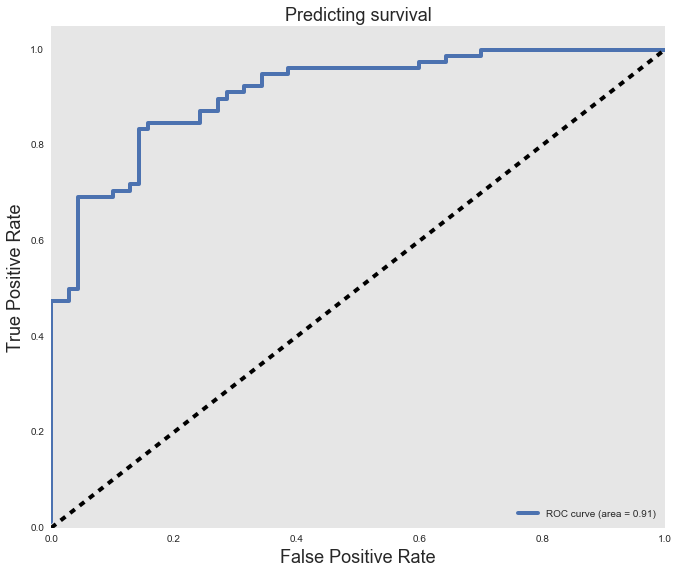

In [30]:
""" Plot AUC"""

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(Y_test, y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Predicting survival', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [31]:
temp_df = final_df.T
temp_df = temp_df[[ind for ind, x in enumerate(df['Year']) if x > 1980]].T
ftest_df = temp_df.reset_index(drop=True)

temp_df = df.T
temp_df = temp_df[[ind for ind, x in enumerate(df['Year']) if x > 1980]].T
fff_df = temp_df.reset_index(drop=True)

In [32]:
X = ftest_df
y = fff_df['imdbRating']>=fff_df['imdbRating'].median()  #8.3

In [33]:
etc = ExtraTreesClassifier(random_state=randy_state, n_jobs=-1)
etc.fit(X, y)

cv = KFold(len(y), shuffle=True)
scores = cross_val_score(etc, X, y, cv=cv, n_jobs=-1)

In [34]:
scores.mean()

0.5816993464052288